<a href="https://colab.research.google.com/github/Anirudh-R-1201/Football_xG/blob/master/testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving np_shots.csv to np_shots.csv


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [28]:
import pandas as pd
import numpy as np
from IPython.display import display
from collections import OrderedDict, Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier
from xgboost import XGBClassifier
from sklearn import preprocessing, model_selection, metrics
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import make_scorer, matthews_corrcoef, brier_score_loss, log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours, TomekLinks
from imblearn.metrics import *
import matplotlib.pyplot as plt
import seaborn as sns
!pip install scikit-plot
import scikitplot as skplt

import warnings
warnings.filterwarnings("ignore")

In [29]:
np_shots = pd.read_csv('np_shots.csv')

feature_cols = ['play_pattern', 'under_pressure', 'body_part', 'technique', 'first_time',
                'follows_dribble', 'redirect', 'one_on_one', 'open_goal', 'deflected',
                'assisted', 'distance', 'angle']

features = np_shots[feature_cols]
labels = np_shots['goal']

features = features.fillna(0)
labels = labels.fillna(0)
cat_cols = ['play_pattern', 'under_pressure', 'body_part', 'technique', 'first_time',
                'follows_dribble', 'redirect', 'one_on_one', 'open_goal', 'deflected']

cat_features = features[cat_cols]
features = features.drop(cat_cols, axis=1)

le = preprocessing.LabelEncoder()
cat_features = cat_features.apply(le.fit_transform)
features = features.merge(cat_features, left_index=True, right_index=True)

In [30]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000): 
        with pd.option_context("display.max_columns", 1000): 
            display(df.head().transpose())
            
display_all(features)

,0,1,2,3,4
assisted,0.000000,1.000000,1.000000,1.000000,1.000000
distance,28.270479,35.503943,25.824020,20.718349,29.167105
angle,6.295429,32.929153,16.189206,70.253163,42.220833
play_pattern,8.000000,6.000000,4.000000,6.000000,8.000000
under_pressure,1.000000,0.000000,0.000000,0.000000,0.000000
body_part,0.000000,0.000000,0.000000,0.000000,0.000000
technique,4.000000,4.000000,4.000000,4.000000,4.000000
first_time,0.000000,0.000000,0.000000,0.000000,0.000000
follows_dribble,0.000000,0.000000,0.000000,0.000000,0.000000
redirect,0.000000,0.000000,0.000000,0.000000,0.000000


In [33]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.30, shuffle=True, stratify=labels, random_state=42)

def get_class_dist(data, name):
    unique, counts = np.unique(data, return_counts=True)
    pct = 100*(counts/len(data))
    d = dict(zip(unique, zip(counts, pct)))
    print(len(data), 'total examples in %s' % name)
    for key, values in d.items():
        print('class %d: %d examples,' % (key, values[0]), "{0:.2f}%".format(values[1]))
    print('')
    return

get_class_dist(data=y_train, name='y_train')
get_class_dist(data=y_test, name='y_test')

1186 total examples in y_train
class 0: 1088 examples, 91.74%
class 1: 98 examples, 8.26%

509 total examples in y_test
class 0: 467 examples, 91.75%
class 1: 42 examples, 8.25%



In [34]:
cat_cols = ['play_pattern', 'under_pressure', 'body_part', 'technique', 'first_time','follows_dribble', 'redirect', 'one_on_one', 'open_goal', 'deflected']

cat_cols_ind = []
for key in cat_cols:
    ind = X_train.columns.get_loc(key)
    cat_cols_ind.append(ind)

smote = SMOTENC(categorical_features=cat_cols_ind, random_state=42)
features_resampled, labels_resampled= smote.fit_resample(features, labels)
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(features_resampled, labels_resampled,test_size=0.25, shuffle=True, random_state=42)
get_class_dist(data=y_train_res, name='y_train_res')

2332 total examples in y_train_res
class 0: 1159 examples, 49.70%
class 1: 1173 examples, 50.30%



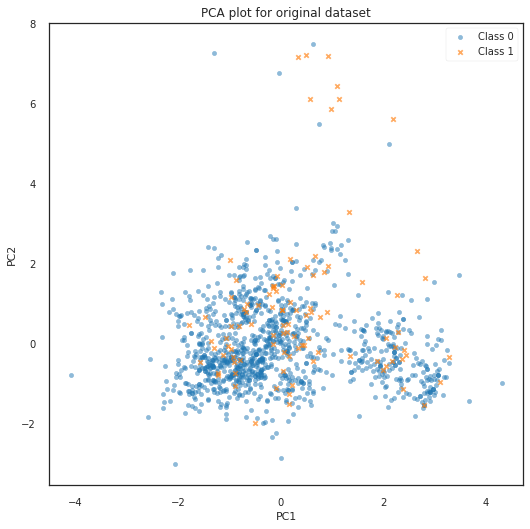

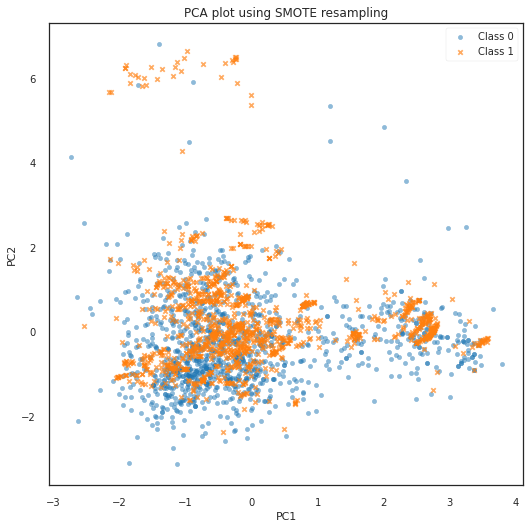

In [35]:
def pca_plot(X, y, title):
    X = StandardScaler().fit_transform(X)
    pca = PCA(n_components = 2)
    X_pc = pca.fit_transform(X)
    
    plt.style.use('seaborn-notebook')
    fig, ax = plt.subplots(figsize=(8.5, 8.5))
    mask = y==0
    ax.scatter(X_pc[mask, 0], X_pc[mask, 1], color='#1f77b4', marker='o', label='Class 0', alpha=0.5, s=20)
    ax.scatter(X_pc[~mask, 0], X_pc[~mask, 1], color='#ff7f0e', marker='x', label='Class 1', alpha=0.65, s=20)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.legend(loc='best')
    plt.title(title);
    return

pca_plot(X_train, y_train, title='PCA plot for original dataset')
pca_plot(X_train_res, y_train_res, title='PCA plot using SMOTE resampling')

In [36]:
def barplot_comparison(df, x='name', y1='mcc', y2='brier_loss', figsize=(18, 8)):
    sns.set(style='white')

    f, axs = plt.subplots(ncols=2, figsize=figsize, sharey=False)
    
    sns.barplot(x=x, y=y1, data=df, palette='muted', ax=axs[0])
    sns.barplot(x=x, y=y2, data=df, palette='muted', ax=axs[1])

    axs[0].yaxis.grid(True)
    axs[0].set(xlabel="", ylim=(min(df[y1]-0.02),max(df[y1]+0.02)))
    axs[1].yaxis.grid(True)
    axs[1].set(xlabel="", ylim=(min(df[y2]-0.02),max(df[y2]+0.02)))
    sns.despine(trim=True, left=True);
    
    return

def boxplot_comparison(df, x='name', y1='mcc', y2='brier_loss', figsize=(18, 8)):
    sns.set(style='white')

    f, axs = plt.subplots(ncols=2, figsize=figsize, sharey=False)

    sns.boxplot(x=x, y=y1, data=df,whis='range', palette='muted', ax=axs[0])
    sns.boxplot(x=x, y=y2, data=df,whis='range', palette='muted', ax=axs[1])

    sns.swarmplot(x=x, y=y1, data=df, size=4, color='.3', linewidth=0, ax=axs[0])
    sns.swarmplot(x=x, y=y2, data=df, size=4, color='.3', linewidth=0, ax=axs[1])

    axs[0].yaxis.grid(True)
    axs[0].set(xlabel="", ylim=(min(df[y1]-0.02),max(df[y1]+0.02)))
    axs[1].yaxis.grid(True)
    axs[1].set(xlabel="", ylim=(min(df[y2]-0.02),max(df[y2]+0.02)))
    sns.despine(trim=True, left=True);
    
    return

def check_model(model, resampling, calibrate, X=features, y=labels, cat_features=cat_cols_ind,
                k=5, print_res=True, plot_pca=False, random_state=42):
    
    X = np.array(X)
    y = np.array(y)
    
    cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=random_state)
    
    mcc = []
    brier = []
    actual_goals = []
    pred_goals = []
    model_name = model.__class__.__name__

    for ii, (train_index, valid_index) in enumerate(cv.split(X, y)):
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if resampling == None:
            res = 'no'
        else:
            X_train, y_train = resampling.fit_resample(X_train, y_train)
            res = resampling.__class__.__name__

        if calibrate == None:
            calibrated_probs = 'uncalibrated probabilities'
            model.fit(X_train, y_train)
        else:
            model = CalibratedClassifierCV(model, cv=2, method=calibrate)
            model.fit(X_train, y_train)
            calibrated_probs = '%s calibration' % calibrate    
            
        y_pred = model.predict(X_valid)
        y_pred_proba = model.predict_proba(X_valid)[:,1]
        
        actual_goals.append(sum(y_valid))
        pred_goals.append(sum(y_pred_proba))
        mcc.append(matthews_corrcoef(y_valid, y_pred))
        brier.append(brier_score_loss(y_valid, y_pred_proba))
        
        if plot_pca == True and ii == 0:
            pca_plot(X_train, y_train, title='%s with %s resampling (1st fold)'
              % (model_name, res))
        else: pass
    
    df = pd.DataFrame()
    df['model'] = model_name
    df['resampling'] = res
    df['mcc'] = mcc
    df['brier_loss'] = brier
    df['actual_goals'] = actual_goals
    df['predicted_goals'] = pred_goals
    df['goals_diff'] = abs(df['actual_goals'] - df['predicted_goals'])
    df['calibrated'] = calibrated_probs
    
    if print_res == True:
        print('Method: %s with %s resampling and %s'
              % (model_name, res, calibrated_probs))
        print('Goals:', '{0:.2f}'.format(df['actual_goals'].mean()))
        print('Predicted Goals:', '{0:.2f}'.format(df['predicted_goals'].mean()))
        print('MCC:', '{0:.3f}'.format(df['mcc'].mean()))
        print('Brier Loss:', '{0:.3f}'.format(df['brier_loss'].mean()))
        print('')
    else: pass

    return df

Method: RandomForestClassifier with no resampling and uncalibrated probabilities
Goals: 28.00
Predicted Goals: 28.77
MCC: 0.164
Brier Loss: 0.075

Method: RandomForestClassifier with SMOTENC resampling and uncalibrated probabilities
Goals: 28.00
Predicted Goals: 60.41
MCC: 0.146
Brier Loss: 0.119

Method: RandomForestClassifier with TomekLinks resampling and uncalibrated probabilities
Goals: 28.00
Predicted Goals: 30.71
MCC: 0.213
Brier Loss: 0.075

Method: RandomForestClassifier with EditedNearestNeighbours resampling and uncalibrated probabilities
Goals: 28.00
Predicted Goals: 42.00
MCC: 0.217
Brier Loss: 0.085

Method: RandomForestClassifier with SMOTETomek resampling and uncalibrated probabilities
Goals: 28.00
Predicted Goals: 55.08
MCC: 0.117
Brier Loss: 0.116

Method: RandomForestClassifier with SMOTEENN resampling and uncalibrated probabilities
Goals: 28.00
Predicted Goals: 43.78
MCC: 0.140
Brier Loss: 0.103



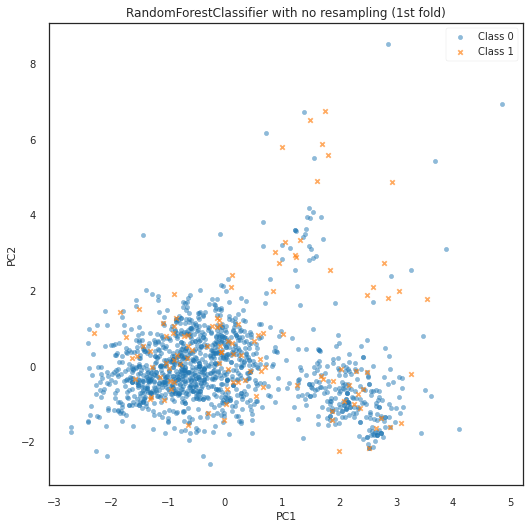

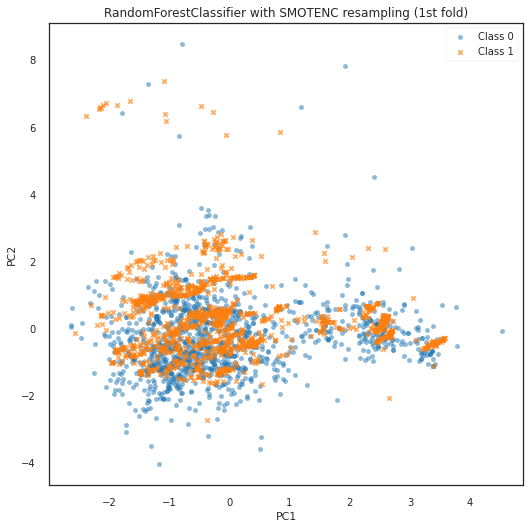

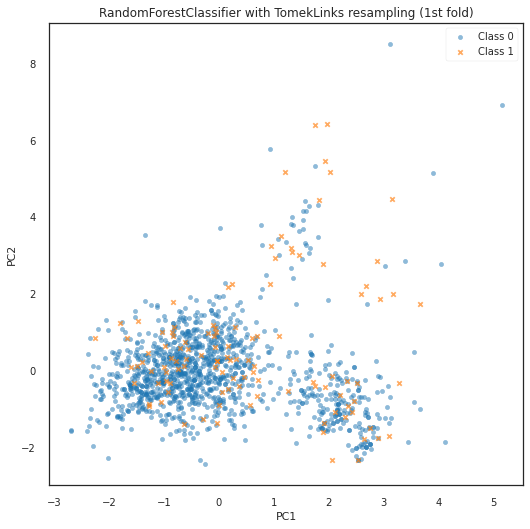

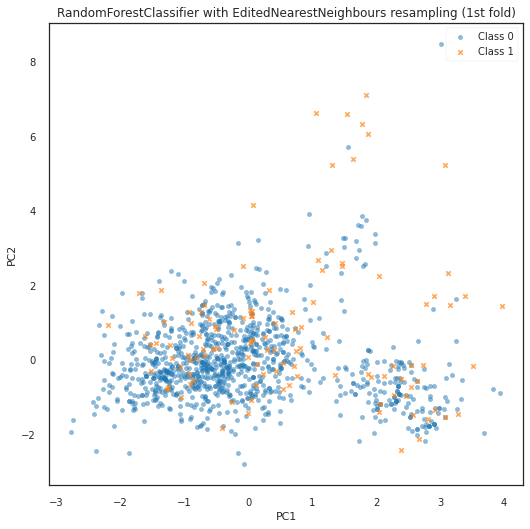

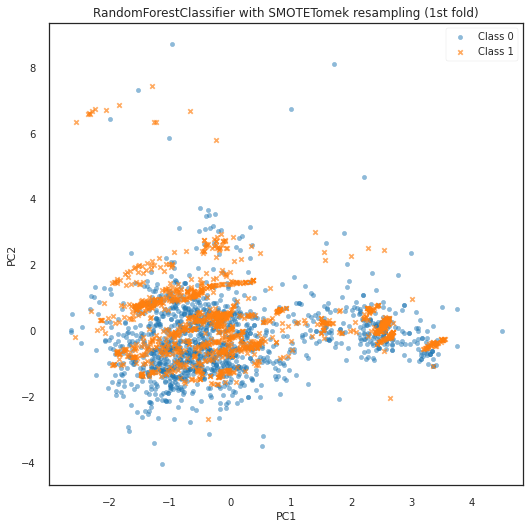

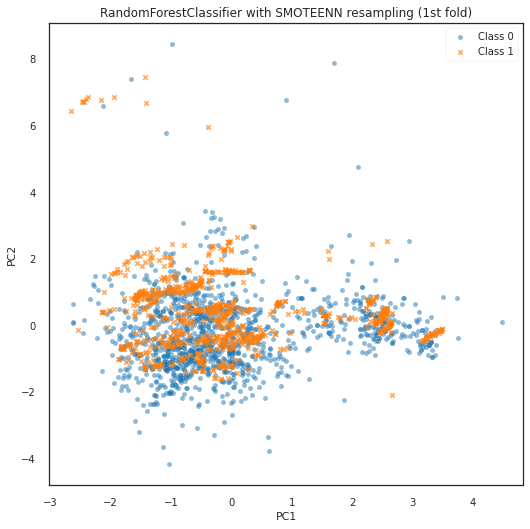

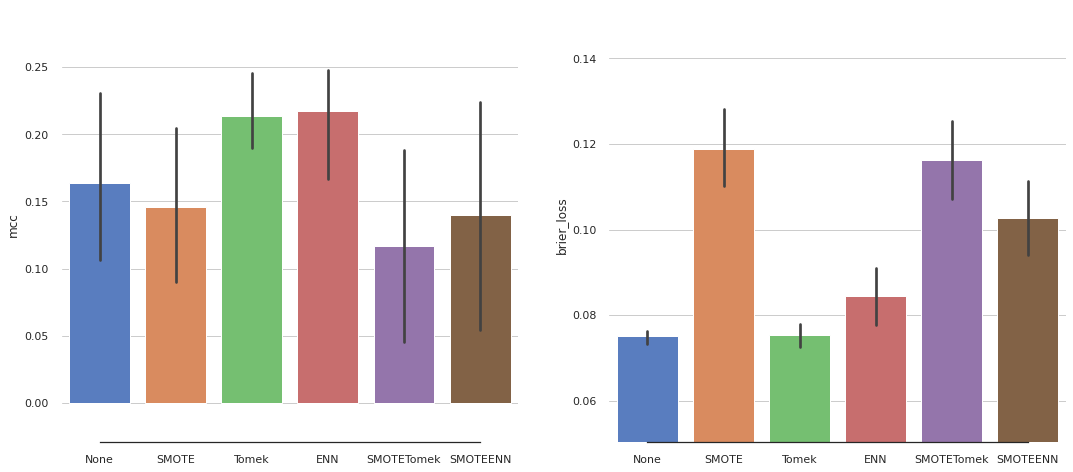

In [37]:
tomek = TomekLinks(n_jobs=-1, random_state=42)
enn = EditedNearestNeighbours(n_jobs=-1, random_state=42)
smote_tomek = SMOTETomek(smote=smote, tomek=tomek, random_state=42)
smote_enn = SMOTEENN(smote=smote, enn=enn, random_state=42)
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)

models = []
models.append(('None', rf, None, None))
models.append(('SMOTE', rf, smote, None))
models.append(('Tomek', rf, tomek, None))
models.append(('ENN', rf, enn, None))
models.append(('SMOTETomek', rf, smote_tomek, None))
models.append(('SMOTEENN', rf, smote_enn, None))

results_df = pd.DataFrame()
for name, model, resampling, calibrate in models:
    result = check_model(model, resampling, calibrate, plot_pca=True)
    result['name'] = name
    results_df = results_df.append(result)

barplot_comparison(results_df)

Method: RandomForestClassifier with no resampling and sigmoid calibration
Goals: 28.00
Predicted Goals: 27.61
MCC: 0.073
Brier Loss: 0.070

Method: RandomForestClassifier with SMOTENC resampling and sigmoid calibration
Goals: 28.00
Predicted Goals: 75.17
MCC: 0.163
Brier Loss: 0.132

Method: RandomForestClassifier with TomekLinks resampling and sigmoid calibration
Goals: 28.00
Predicted Goals: 28.98
MCC: 0.116
Brier Loss: 0.070

Method: RandomForestClassifier with EditedNearestNeighbours resampling and sigmoid calibration
Goals: 28.00
Predicted Goals: 37.26
MCC: 0.221
Brier Loss: 0.074

Method: RandomForestClassifier with SMOTETomek resampling and sigmoid calibration
Goals: 28.00
Predicted Goals: 69.78
MCC: 0.147
Brier Loss: 0.127

Method: RandomForestClassifier with SMOTEENN resampling and sigmoid calibration
Goals: 28.00
Predicted Goals: 55.11
MCC: 0.164
Brier Loss: 0.112



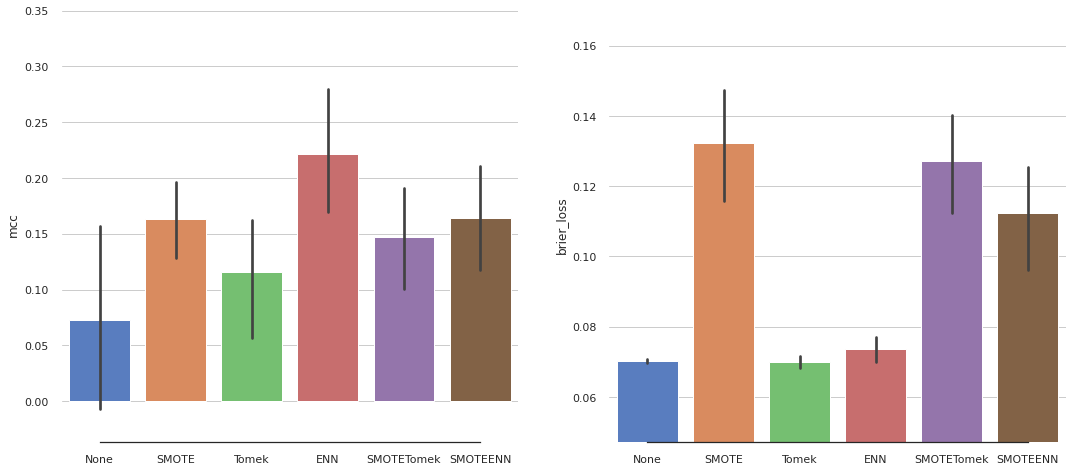

In [38]:
models = []
models.append(('None', rf, None, 'sigmoid'))
models.append(('SMOTE', rf, smote, 'sigmoid'))
models.append(('Tomek', rf, tomek, 'sigmoid'))
models.append(('ENN', rf, enn, 'sigmoid'))
models.append(('SMOTETomek', rf, smote_tomek, 'sigmoid'))
models.append(('SMOTEENN', rf, smote_enn, 'sigmoid'))

results_df = pd.DataFrame()
for name, model, resampling, calibrate in models:
    result = check_model(model, resampling, calibrate)
    result['name'] = name
    results_df = results_df.append(result)
    
barplot_comparison(results_df)

RF:
Goals: 42
Predicted Goals: 45.78
MCC: 0.054
Brier Loss: 0.078

RF + Isotonic:
Goals: 42
Predicted Goals: 45.44
MCC: 0.163
Brier Loss: 0.071

RF + Sigmoid:
Goals: 42
Predicted Goals: 43.56
MCC: 0.000
Brier Loss: 0.071



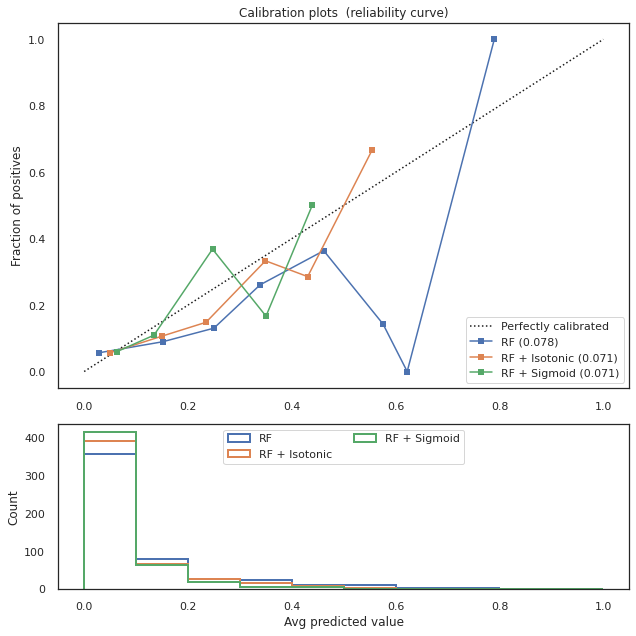

In [39]:
def plot_calibration_curve(name, model, cv, resampling=None,
                           X_train=X_train, y_train=y_train,
                           X_test=X_test, y_test=y_test):

    if resampling == None:
        pass
    else:
        X_train, y_train = resampling.fit_resample(X_train, y_train) 
       
    sigmoid = CalibratedClassifierCV(model, cv=cv, method='sigmoid')
    
    isotonic = CalibratedClassifierCV(model, cv=cv, method='isotonic')

    fig = plt.figure(figsize=(9, 9))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for clf, name in [(model, name), (isotonic, name + ' + Isotonic'),(sigmoid, name + ' + Sigmoid')]:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_pred_proba = clf.predict_proba(X_test)[:, 1]
        clf_score = brier_score_loss(y_test, y_pred_proba, pos_label=labels.max())
        
        print("%s:" % name)
        print('Goals:', (sum(y_test)))
        print('Predicted Goals:', '{0:.2f}'.format((sum(y_pred_proba))))
        print('MCC:', '{0:.3f}'.format(matthews_corrcoef(y_test, y_pred)))
        print('Brier Loss:', '{0:.3f}'.format(clf_score))
        print('')

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, y_pred_proba, n_bins=10)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (name, clf_score))

        ax2.hist(y_pred_proba, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Avg predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()
    
plot_calibration_curve("RF", model=rf, cv = 5, resampling=None)

In [40]:
!pip install dtreeviz
from dtreeviz.trees import *

In [41]:
from ipywidgets import interactive
def plot_tree(tree_num=4, depth=2, min_leaf=1, max_feat='sqrt'):
    m = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42,
                               max_depth=depth,
                               min_samples_leaf=min_leaf,
                               max_features=max_feat)
    m.fit(X_train, y_train)
    estimator = m.estimators_[tree_num]
    
    viz = dtreeviz(estimator, X_train, y_train,
                   target_name='outcome', 
                   feature_names=X_train.columns, 
                   class_names=['no goal', 'goal'],
                   orientation='TD')  
    display(viz)
    return estimator

inter=interactive(plot_tree,
                  tree_num=(0, 99),
                  depth=(1, 4),
                  min_leaf=[1, 3, 5, 10, 25],
                  max_feat=[1, 0.5, 'sqrt', 'log2'])

display(inter)

interactive(children=(IntSlider(value=4, description='tree_num', max=99), IntSlider(value=2, description='dept…

0.07513452725183378


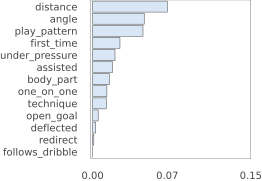

In [42]:
!pip install rfpimp
from rfpimp import * 


m = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

X = features
y = labels

m.fit(X, y)
scores = cross_val_score(m, X, y, cv=cv, scoring='brier_score_loss')
print(scores.mean()*-1)
imp = importances(m, X, y, n_samples=-1, metric='brier_score_loss')
viz = plot_importances(imp)
viz

0.07556684993286114


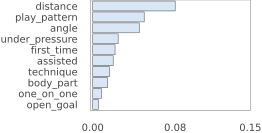

In [43]:
def elim_feats(X, imp=imp, thresh=0.005):
    return X[list(imp[imp.values>=thresh].index.values)]

X_new = elim_feats(X=X)

m.fit(X_new, y)
scores = cross_val_score(m, X_new, y, cv=cv, scoring='brier_score_loss')
print(scores.mean()*-1)

imp = importances(m, X_new, y, n_samples=-1, metric='brier_score_loss')
viz = plot_importances(imp)
viz